# Project 6b - Linear system perspective

We have heretofore been approaching the discretization of spatial derivatives as a *convolution* operation, in which we slide a second derivative kernel over a function in order to get a function response.  An important fact is that convolution is a linear operation, which means that it's transitive and associative and all that, but stuff, but also that we can rewrite the convolution operation by a matrix.  To see this, recall that for some arbitrary location in the domain, we have as a right hand side
$$
\frac{\partial u_i}{\partial t} = \frac{k}{\Delta x^2} \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} \begin{bmatrix} u_{i-1} \\ u_i \\ u_{i+1}\end{bmatrix}.
$$
Of course, we also have that 
$$
\frac{\partial u_{i+1}}{\partial t} = \frac{k}{\Delta x^2} \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} \begin{bmatrix} u_{i} \\ u_{i+1} \\ u_{i+2}\end{bmatrix}.
$$
If we put these together, we could write the equation for both locations simultaneously as 
$$
\begin{bmatrix}\frac{\partial u_{i}}{\partial t} \\ \frac{\partial u_{i+1}}{\partial t}\end{bmatrix}  = \frac{k}{\Delta x^2} \begin{bmatrix} 1 & -2 & 1 & 0 \\ 0 & 1 & -2 & 1 \end{bmatrix} \begin{bmatrix} u_{i-1} \\ u_{i} \\ u_{i+1} \\ u_{i+2}\end{bmatrix}.
$$
If we expanded this to every location in the domain, we could write this rather simply as 
$$
\frac{\partial \mathbf{u}}{\partial t} = A \mathbf{u},
$$
where
$$
A = \frac{k}{\Delta x^2}\begin{bmatrix}     -2 &  1 & 0 & \cdots & 0 & 0 & 1 \\
                     1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
                     0 &  1 & 2 & \cdots & 0 & 0 & 0 \\
                     \vdots &  \vdots & \vdots & \ddots &\vdots  & \vdots & \vdots \\
                     0 & 0 & 0 & \cdots  & 1 & -2 & 1 \\
                     1 & 0 & 0 & \cdots  & 0 & 1 & -2
                      \end{bmatrix},
$$
and where we have assumed periodic boundary conditions.  To impose other boundary conditions, we can simply modify the rows commensurately with the formulae that we've seen previously.  For example, to handle the case where we have a Dirichlet boundary on the left hand side, and a Neumann boundary on the right, we can write
$$
\frac{\partial \mathbf{u}}{\partial t} = A \mathbf{u} + \mathbf{b},
$$
where
$$
A = \frac{k}{\Delta x^2} \begin{bmatrix}     0 &  0 & 0 & \cdots & 0 & 0 & 0 \\
                     1 & -2 & 1 & \cdots & 0 & 0 & 0 \\
                     0 &  1 & 2 & \cdots & 0 & 0 & 0 \\
                     \vdots &  \vdots & \vdots & \ddots &\vdots  & \vdots & \vdots \\
                     0 & 0 & 0 & \cdots  & 1 & -2 & 1 \\
                     0 & 0 & 0 & \cdots  & 0 & 2 & -2
                      \end{bmatrix},
$$
and 
$$
\mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ \frac{2 C}{\Delta x} \end{bmatrix}.
$$
**Modify your diffusion problem to utilize this matrix formulation, then ensure that your solutions are equivalent to those you computed with the convolution approach.  (Bonus credibility if you can write this code to handle either Dirichlet or Neumann conditions on either boundary.)  (Bonus bonus credibility if you can make this work with a sparse matrix data type.)**


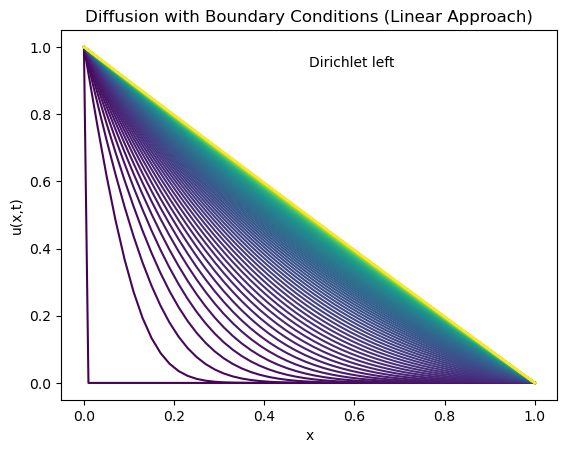

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ode_methods as om

def get_dt_max(dx,k):
    return dx**2/(2*k)

class DiffusionLinear:
    def __init__(self, nx, dx, k=0.01, dir_left=False, dir_right=False, neu_left=False, neu_right=False):
        self.nx = nx
        self.dx = dx
        self.k = k
        self.dir_left = dir_left
        self.dir_right = dir_right
        self.neu_left = neu_left
        self.neu_right = neu_right
        self.A = self.create_matrix()

    def create_matrix(self):
        # Initialize matrix
        A = np.zeros((self.nx, self.nx))

        # Fill the matrix
        for i in range(self.nx):
            if i == 0 or i == self.nx - 1: # First and last row are boundary conditions
                A[i, i] = 0
            else:
                A[i, i - 1] = 1
                A[i, i] = -2
                A[i, i + 1] = 1
        
        return A

    def rhs(self, t, u):
        u_bounded = u.copy()
        dudt = self.k / self.dx**2 * np.dot(self.A, u_bounded) # Compute the right-hand side (du/dt)
        if self.neu_right:
            dudt[-1] = dudt[-2]
        if self.neu_left:
            dudt[0] = dudt[1]
        return dudt

# Setup
L = 1.0  # Length of the domain
nx = 101  # Number of grid points
dx = L / (nx - 1)  # Grid spacing
x = np.linspace(0, L, nx)  # Position array
u0 = np.zeros(nx)  # Initial condition array
d_left = True
d_right = False
n_left = False
n_right = False
if d_left or n_right:
    u0[0] = 1
if d_right or n_left:
    u0[-1] = 1

# Parameters
k = 0.01 
dt = 0.005#get_dt_max(dx,k)  # Time step
t_span = (0, 50)  

diffusion_model = DiffusionLinear(nx, dx, k, d_left, d_right, n_left, n_right)
euler_method = om.Euler()
integrator = om.Integrator(diffusion_model, euler_method)

# Solve
t, u = integrator.integrate(t_span, dt, u0)

# Visualization
cmap = plt.cm.viridis
for tt, uu in zip(t[::100], u[::100]): # Plot every 100th solution
    plt.plot(x, uu, color=cmap(tt/t[-1]))
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Diffusion with Boundary Conditions (Linear Approach)")
# Show which conditions are active on the plot, text box upper right
if d_left:
    plt.text(0.5, 0.9, "Dirichlet left", transform=plt.gca().transAxes)
if d_right:
    plt.text(0.5, 0.865, "Dirichlet right", transform=plt.gca().transAxes)
if n_left:
    plt.text(0.5, 0.830, "Neumann left", transform=plt.gca().transAxes)
if n_right:
    plt.text(0.5, 0.795, "Neumann right", transform=plt.gca().transAxes)
plt.show()